In [ ]:
#特征预分析
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import xgboost as xgb

# 导入自定义模块
import ehr_utils
import ehr_models

data_path = 'data_processed/benbu_baseline_cleaned_onehot_simulated80.csv'
# 加载原始数据
X_train, X_test, y_train, y_test = ehr_utils.preprocess_ehr_train_test_data(data_path)

# 设置 XGBoost 参数
xgb_params = dict(colsample_bytree=1.0,
                  device='gpu',
                  eval_metric="auc",
                  gamma=0.0,
                  learning_rate=0.022403069086742198,
                  max_depth=5,
                  min_child_weight=100,
                  n_estimators=589,
                  n_jobs=-1,
                  random_state=42,
                  reg_alpha=0.14314863930500873,
                  reg_lambda=100.0,
                  subsample=0.7300248552604385)
xgb_model = ehr_models.get_model('XGBoost', True)



总特征数：96，需要log1p变换的特征数：66
训练集样本数：8000，验证集样本数：2000


In [4]:
# 遍历所有特征
from sklearn.metrics import roc_auc_score, roc_curve
# ========== 2. 单特征训练XGBoost并计算AUC ==========
feature_auc = []  # 存储 (特征名, 原始AUC)
feature_roc_data = {}

for feature in X_train.columns:
    # 单特征数据
    X_train_single = X_train[[feature]]
    X_test_single = X_test[[feature]]
    
    # 训练模型
    model = xgb.XGBClassifier(**xgb_params)
    model.fit(X_train_single, y_train)
    
    # 预测概率+计算AUC
    y_pred_prob = model.predict_proba(X_test_single)[:, 1]
    auc = roc_auc_score(y_test, y_pred_prob)
    feature_auc.append((feature, auc))
    
    # 保存ROC数据（用于后续ROC曲线）
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    feature_roc_data[feature] = (fpr, tpr)

# ========== 3. AUC排序 + 归一化 ==========
# 步骤1：按原始AUC降序排序
feature_auc_sorted = sorted(feature_auc, key=lambda x: x[1], reverse=True)
features_sorted = [name for name, auc in feature_auc_sorted]
aucs_sorted = [auc for name, auc in feature_auc_sorted]

# 步骤2：归一化AUC（Min-Max归一化，缩放到0-1）
aucs_array = np.array(aucs_sorted)
aucs_normalized = (aucs_array - aucs_array.min()) / (aucs_array.max() - aucs_array.min())

# 合并：特征名 + 原始AUC + 归一化AUC
feature_auc_norm = pd.DataFrame({
    'feature': features_sorted,
    'auc_original': aucs_sorted,
    'auc_normalized': aucs_normalized
})

# 打印前20个特征的排序结果（验证）
print("单特征AUC排序（前20）：")
print(feature_auc_norm.head(20))

# ========== 4. 可视化：归一化AUC排序图（所有特征/前20特征） ==========
# ========== 4. 可视化：旋转90度（横坐标为特征，纵坐标为归一化AUC） ==========
top_n = 80  # 取前20个特征（避免拥挤）
top_features = feature_auc_norm.head(top_n)

plt.figure(figsize=(12, 6))  # 调整画布尺寸（宽>高，适配水平特征标签）
# 绘制垂直条形图
bars = plt.bar(
    top_features['feature'],  # 横坐标：特征名
    top_features['auc_normalized'],  # 纵坐标：归一化AUC
    color=plt.cm.viridis(np.linspace(0, 1, top_n))  # 渐变颜色
)

# # 添加数值标签（显示原始AUC和归一化值）
# for i, bar in enumerate(bars):
#     height = bar.get_height()
#     original_auc = top_features['auc_original'].iloc[i]
#     plt.text(
#         bar.get_x() + bar.get_width()/2,  # 标签水平居中
#         height + 0.01,  # 标签在条形上方
#         f'Norm: {height:.3f}\nAUC: {original_auc:.3f}',
#         ha='center', va='bottom', fontsize=8
#     )

# 优化特征标签显示（旋转45度避免重叠）
plt.xticks(
    rotation=45,  # 旋转标签
    ha='right',   # 右对齐
    fontsize=9
)

# 图表美化
plt.ylabel('Normalized AUC (0-1)', fontsize=12)
plt.xlabel('Feature', fontsize=12)
plt.title(f'Top {top_n} Single Feature AUC (Normalized)', fontsize=14)
plt.ylim(0, 1.1)  # y轴范围，留出标签空间
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()  # 自动调整布局，避免标签截断

# 保存图片
plt.savefig('single_feature_auc_normalized_ranking_rotated.png', dpi=300, bbox_inches='tight')
plt.show()

c:\Users\mclab\.conda\envs\calculus\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:46:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:53: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\mclab\.conda\envs\calculus\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:46:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\mclab\.conda\envs\calculus\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:46:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:53: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\mclab\.conda\envs\calculus\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:46:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:207:

KeyboardInterrupt: 

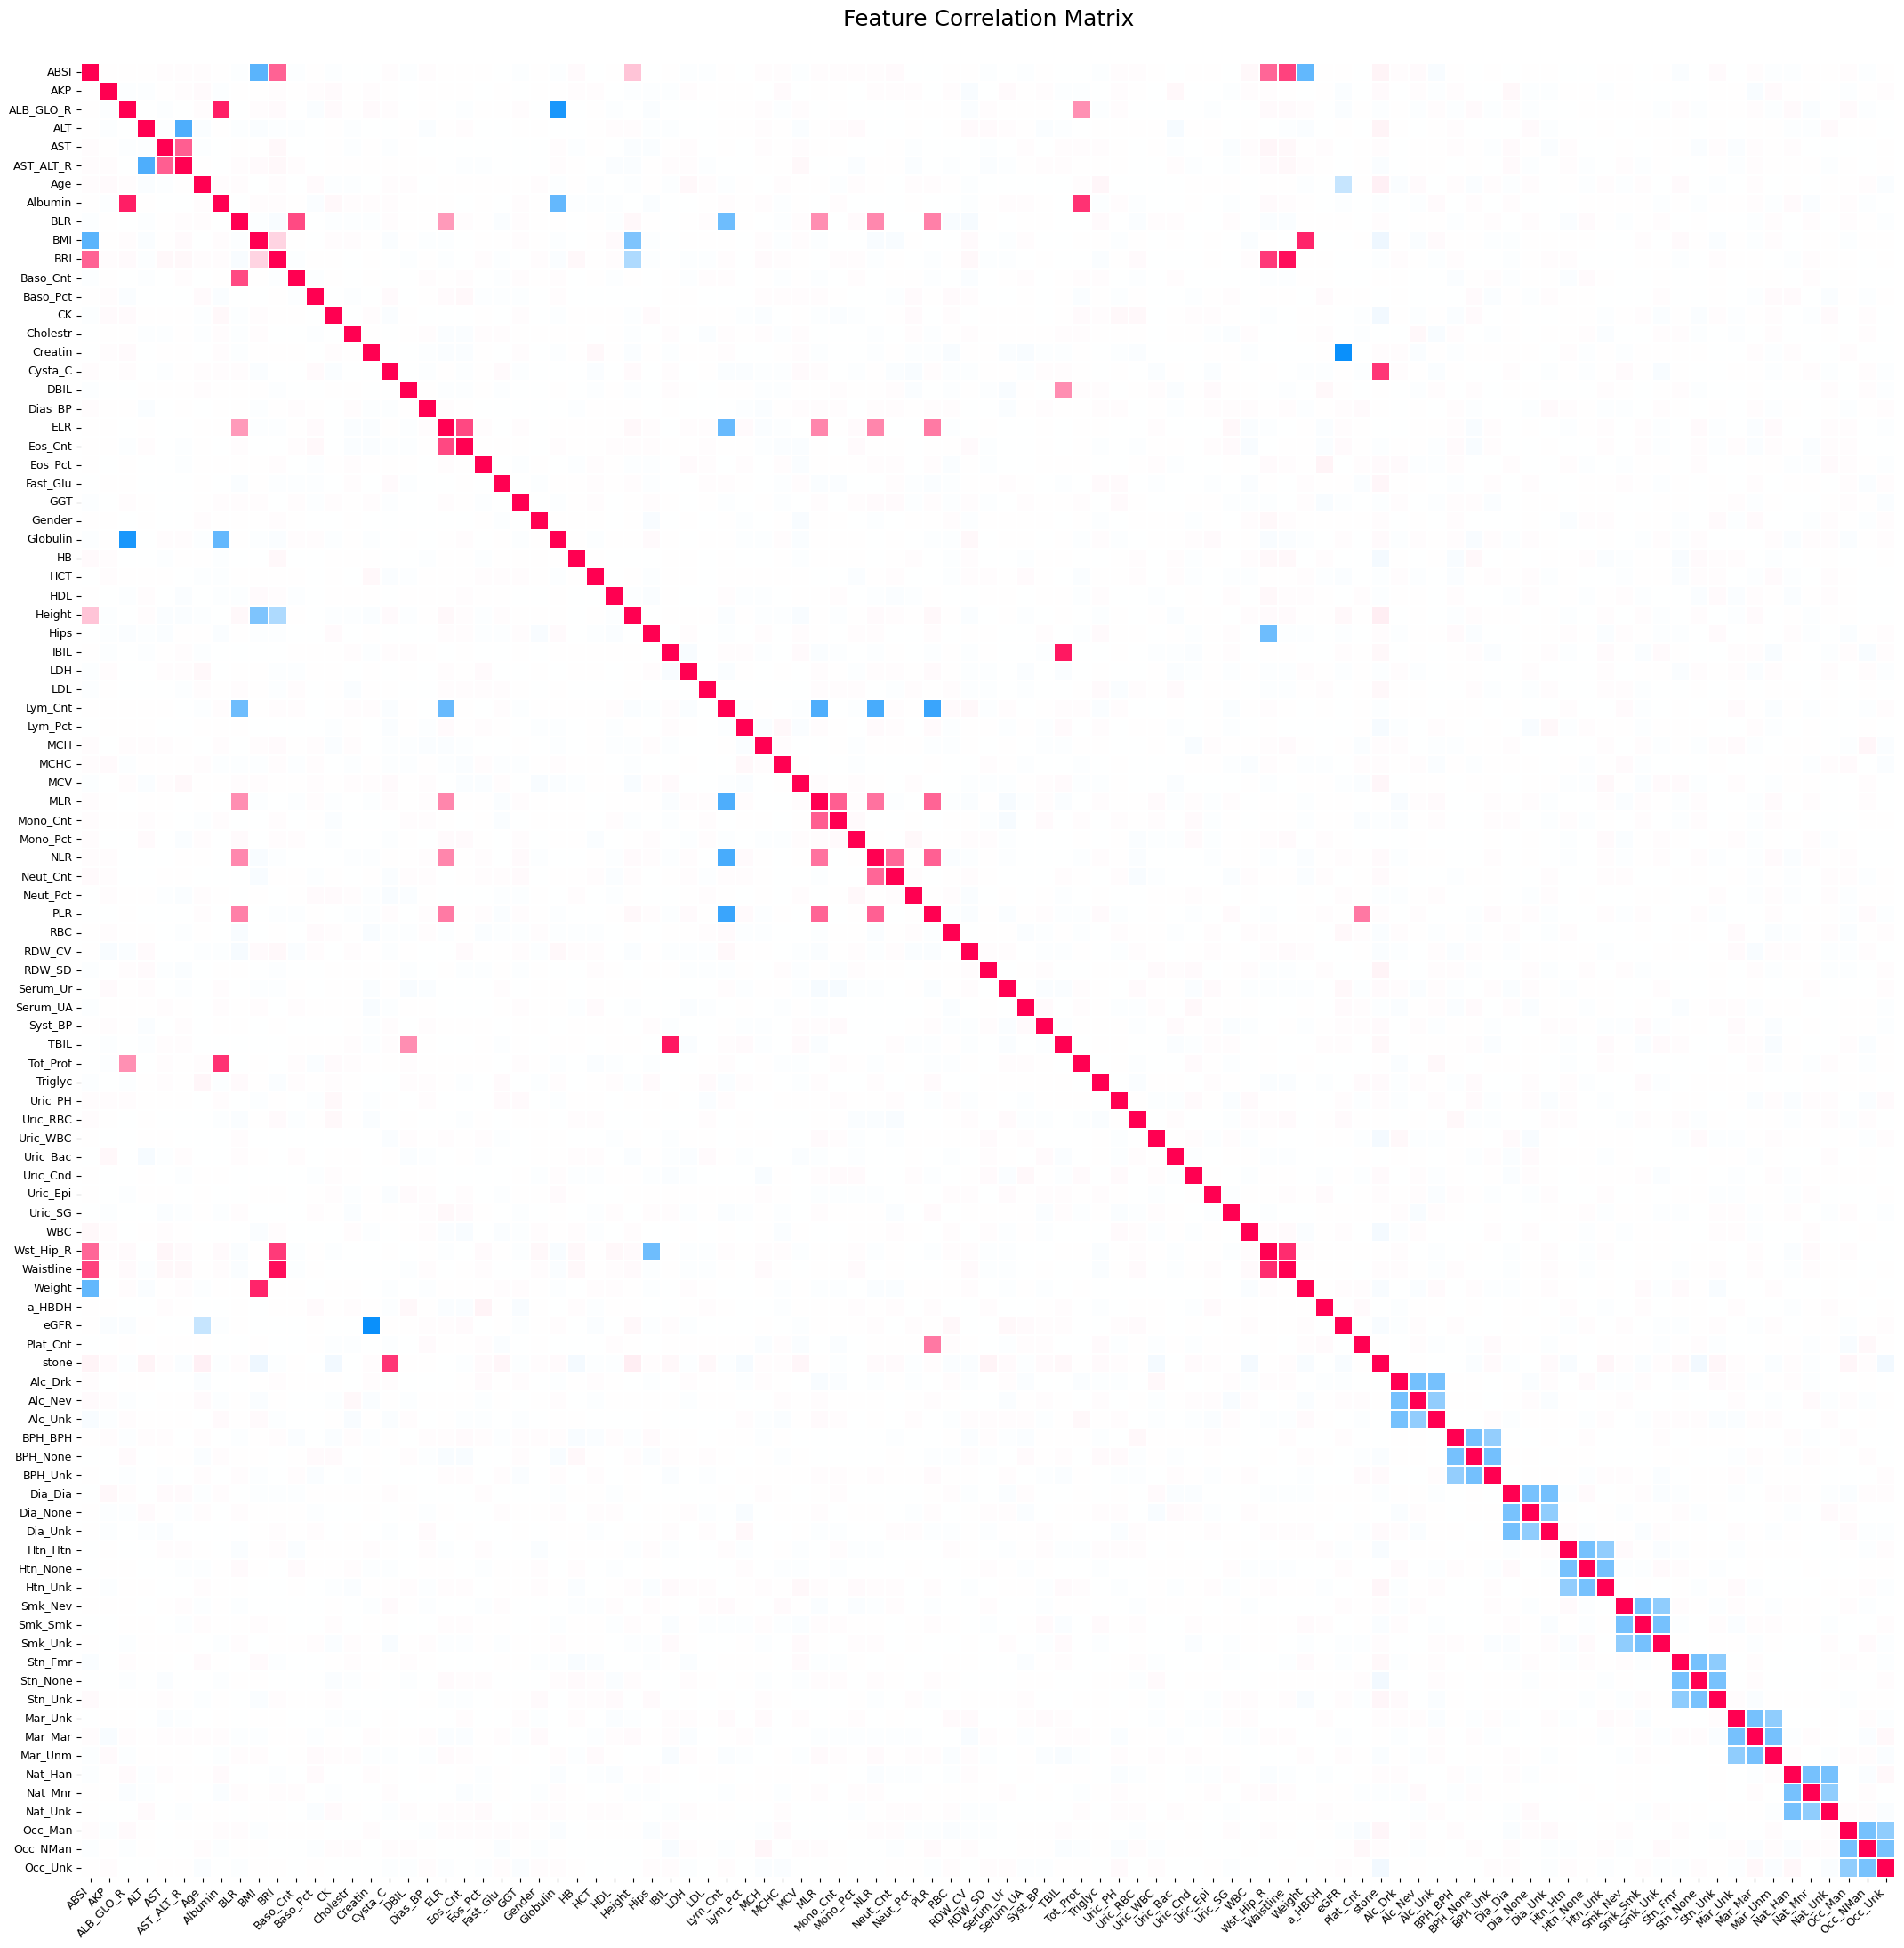

In [3]:
# ========== 1. 定义原特征列表和简写列表（直接复用之前的） ==========
original_features = [
    'ABSI', 'AKP', 'ALB_to_GLO_ratio', 'ALT', 'AST', 'AST_to_ALT_ratio', 'Age',
    'Albumin', 'BLR', 'BMI', 'BRI', 'Basophil_count', 'Basophil_percentage',
    'CK', 'Cholesterol', 'Creatinine', 'Cystatin.C', 'DBIL', 'Diastolic_BP',
    'ELR', 'Eosinophil_count', 'Eosinophil_percentage', 'Fasting_blood_glucose',
    'GGT', 'Gender', 'Globulin', 'HB', 'HCT', 'HDL', 'Height', 'Hips', 'IBIL',
    'LDH', 'LDL', 'Lymphocytes_count', 'Lymphocytes_percentage', 'MCH', 'MCHC',
    'MCV', 'MLR', 'Monocytes_count', 'Monocytes_percentage', 'NLR',
    'Neutrophil_count', 'Neutrophil_percentage', 'PLR', 'RBC', 'RDW.CV',
    'RDW.SD', 'Serum_Urea', 'Serum_Uric_acid', 'Systolic_BP', 'TBIL',
    'Total_protein', 'Triglycerides', 'Uric_PH', 'Uric_RBC', 'Uric_WBC',
    'Uric_bacteria', 'Uric_conductivity', 'Uric_epithelium', 'Uric_specific_gravity',
    'WBC', 'Waist_to_hip_ratio', 'Waistline', 'Weight', 'a_HBDH', 'eGFR',
    'platelets_count', 'stone', 'Alcohol_Drinker', 'Alcohol_Never',
    'Alcohol_Unknown', 'BPH_BPH', 'BPH_None', 'BPH_Unknown', 'Diabete_Diabete',
    'Diabete_None', 'Diabete_Unknown', 'Hypertension_Hypertension',
    'Hypertension_None Hypertension', 'Hypertension_Unknown', 'Smoke_Never',
    'Smoke_Smoker', 'Smoke_Unknown', 'Stone_history_Former Stone Carrier',
    'Stone_history_None', 'Stone_history_Unknown', 'marriage_simplified_Unknown',
    'marriage_simplified_married', 'marriage_simplified_unmarried',
    'nation_Han People', 'nation_Minority Ethnic Groups', 'nation_Unknown',
    'occupation_Manual Laborer', 'occupation_No Manual Laborer',
    'occupation_Unknown'
]

abbr_features = [
    'ABSI', 'AKP', 'ALB_GLO_R', 'ALT', 'AST', 'AST_ALT_R', 'Age',
    'Albumin', 'BLR', 'BMI', 'BRI', 'Baso_Cnt', 'Baso_Pct',
    'CK', 'Cholestr', 'Creatin', 'Cysta_C', 'DBIL', 'Dias_BP',
    'ELR', 'Eos_Cnt', 'Eos_Pct', 'Fast_Glu',
    'GGT', 'Gender', 'Globulin', 'HB', 'HCT', 'HDL', 'Height', 'Hips', 'IBIL',
    'LDH', 'LDL', 'Lym_Cnt', 'Lym_Pct', 'MCH', 'MCHC',
    'MCV', 'MLR', 'Mono_Cnt', 'Mono_Pct', 'NLR',
    'Neut_Cnt', 'Neut_Pct', 'PLR', 'RBC', 'RDW_CV',
    'RDW_SD', 'Serum_Ur', 'Serum_UA', 'Syst_BP', 'TBIL',
    'Tot_Prot', 'Triglyc', 'Uric_PH', 'Uric_RBC', 'Uric_WBC',
    'Uric_Bac', 'Uric_Cnd', 'Uric_Epi', 'Uric_SG',
    'WBC', 'Wst_Hip_R', 'Waistline', 'Weight', 'a_HBDH', 'eGFR',
    'Plat_Cnt', 'stone', 'Alc_Drk', 'Alc_Nev',
    'Alc_Unk', 'BPH_BPH', 'BPH_None', 'BPH_Unk', 'Dia_Dia',
    'Dia_None', 'Dia_Unk', 'Htn_Htn',
    'Htn_None', 'Htn_Unk', 'Smk_Nev',
    'Smk_Smk', 'Smk_Unk', 'Stn_Fmr',
    'Stn_None', 'Stn_Unk', 'Mar_Unk',
    'Mar_Mar', 'Mar_Unm',
    'Nat_Han', 'Nat_Mnr', 'Nat_Unk',
    'Occ_Man', 'Occ_NMan',
    'Occ_Unk'
]

# ========== 2. 读取数据并计算相关矩阵 ==========
data = pd.read_csv('data_processed/benbu_baseline_cleaned_onehot_simulated80.csv')
corr_matrix = data.corr()

# ========== 3. 核心：替换相关矩阵的行/列名为简写 ==========
corr_matrix.index = abbr_features   # 行标签替换为简写
corr_matrix.columns = abbr_features # 列标签替换为简写

# ========== 4. 定义SHAP配色并绘图 ==========
shap_cmap = mcolors.LinearSegmentedColormap.from_list(
    "shap_official", ["#008bfb", "#FFFFFF", "#ff0051"], N=256
)

plt.figure(figsize=(25, 22))  # 适配多特征的画布尺寸
sns.heatmap(
    corr_matrix,
    cmap=shap_cmap,
    center=0, vmin=-1, vmax=1,
    xticklabels=True,  # 自动使用替换后的简写标签
    yticklabels=True,
    square=True,
    linewidths=0.3,
    cbar=False,  # 关键：关闭颜色条（移除颜色柱子）
    # 注释掉原cbar_kws，因为cbar=False时该参数无效
    # cbar_kws={'shrink': 0.8, 'label': 'Correlation Coefficient'}
)

# 优化标签显示（8字符简写，45度旋转即可避免重叠）
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)

# 调整布局+保存
plt.title('Feature Correlation Matrix', fontsize=18, pad=30)
plt.tight_layout()
plt.savefig('corr_matrix_with_abbr_no_colorbar.png', dpi=300, bbox_inches='tight')
plt.show()

总特征数：96，需要log1p变换的特征数：66
训练集样本数：8000，验证集样本数：2000
单特征AUC排序（前20）：
                          feature  auc_original  auc_normalized
0                      Cystatin.C      0.981750        1.000000
1                             BMI      0.543332        0.137333
2                          Height      0.538913        0.128639
3                        Uric_WBC      0.529623        0.110359
4                             MCV      0.529409        0.109938
5          Lymphocytes_percentage      0.527586        0.106351
6                            Hips      0.526062        0.103351
7                              CK      0.525787        0.102810
8            Monocytes_percentage      0.525608        0.102457
9                             LDL      0.524188        0.099663
10                           ABSI      0.523675        0.098654
11             occupation_Unknown      0.522963        0.097253
12                      Waistline      0.522893        0.097116
13  marriage_simplified_unmarried      0

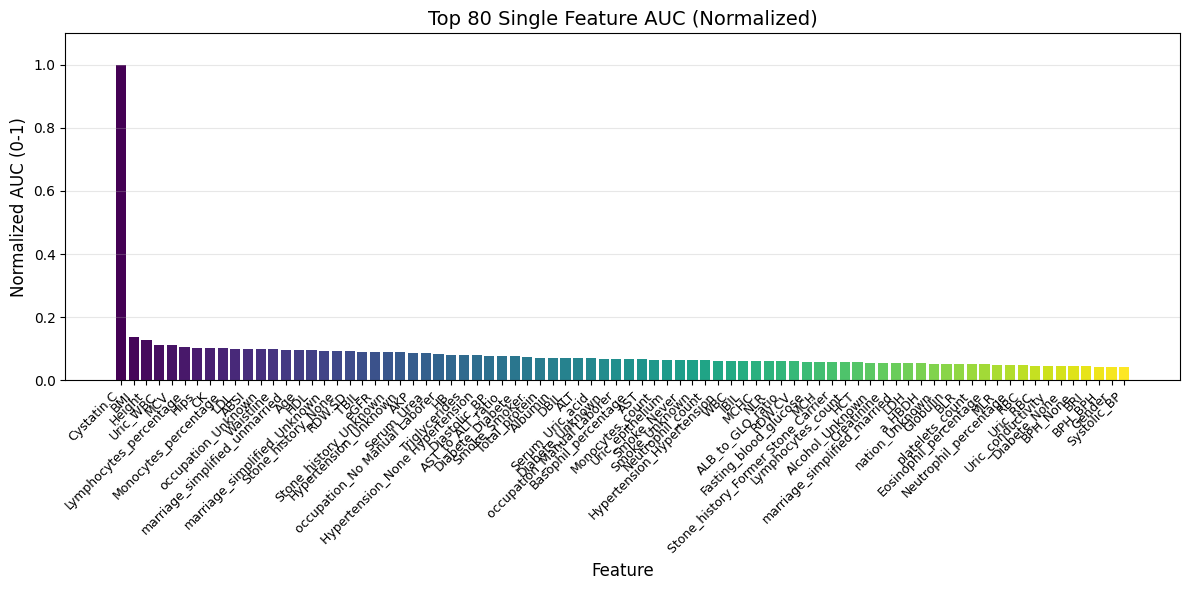

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder

# ========== 1. 加载数据 ==========
X_train, X_test, y_train, y_test = ehr_utils.preprocess_ehr_train_test_data(
    'data_processed/benbu_baseline_cleaned_onehot_simulated80.csv'
)

# 确保y是数值型
if not np.issubdtype(y_train.dtype, np.number):
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)



# XGBoost默认参数（二分类）
xgb_default_params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'learning_rate': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'lambda': 1,
    'alpha': 0,
    'subsample': 1,
    'colsample_bytree': 1,
    'random_state': 42,
    'verbosity': 0
}




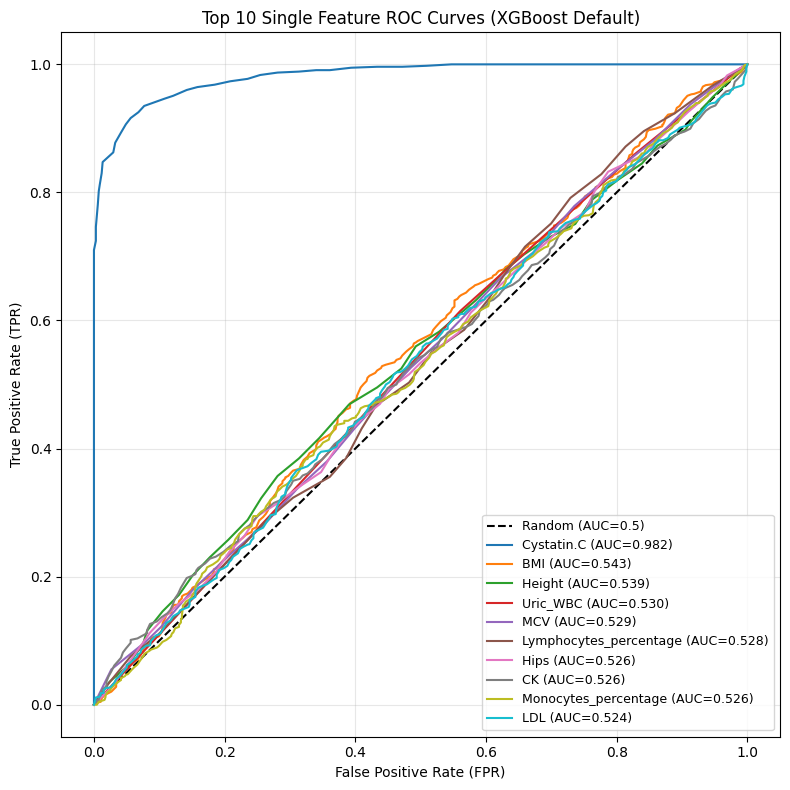

In [15]:
# ========== 5. 绘制前10特征的ROC曲线（复用之前的ROC数据） ==========
plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.5)')

# 前10特征
top10_features = feature_auc_norm['feature'].head(10).tolist()
for feature in top10_features:
    fpr, tpr = feature_roc_data[feature]
    auc = feature_auc_norm[feature_auc_norm['feature']==feature]['auc_original'].values[0]
    plt.plot(fpr, tpr, label=f'{feature} (AUC={auc:.3f})')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Top 10 Single Feature ROC Curves (XGBoost Default)')
plt.legend(loc='lower right', fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('top10_single_feature_roc.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
print(data.columns.tolist())  # 打印所有特征名

['ABSI', 'AKP', 'ALB_to_GLO_ratio', 'ALT', 'AST', 'AST_to_ALT_ratio', 'Age', 'Albumin', 'BLR', 'BMI', 'BRI', 'Basophil_count', 'Basophil_percentage', 'CK', 'Cholesterol', 'Creatinine', 'Cystatin.C', 'DBIL', 'Diastolic_BP', 'ELR', 'Eosinophil_count', 'Eosinophil_percentage', 'Fasting_blood_glucose', 'GGT', 'Gender', 'Globulin', 'HB', 'HCT', 'HDL', 'Height', 'Hips', 'IBIL', 'LDH', 'LDL', 'Lymphocytes_count', 'Lymphocytes_percentage', 'MCH', 'MCHC', 'MCV', 'MLR', 'Monocytes_count', 'Monocytes_percentage', 'NLR', 'Neutrophil_count', 'Neutrophil_percentage', 'PLR', 'RBC', 'RDW.CV', 'RDW.SD', 'Serum_Urea', 'Serum_Uric_acid', 'Systolic_BP', 'TBIL', 'Total_protein', 'Triglycerides', 'Uric_PH', 'Uric_RBC', 'Uric_WBC', 'Uric_bacteria', 'Uric_conductivity', 'Uric_epithelium', 'Uric_specific_gravity', 'WBC', 'Waist_to_hip_ratio', 'Waistline', 'Weight', 'a_HBDH', 'eGFR', 'platelets_count', 'stone', 'Alcohol_Drinker', 'Alcohol_Never', 'Alcohol_Unknown', 'BPH_BPH', 'BPH_None', 'BPH_Unknown', 'Diabete